# Task
Пробую определять Target путем перебора сетки

Смотрю на результаты.

Задача: Поднять значение метрики Precision

# Import modules

In [3]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn.model_selection import train_test_split # сплитование выборки
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from category_encoders import OneHotEncoder, BinaryEncoder

from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

from sklearn import set_config
set_config(transform_output='pandas')

%matplotlib inline
plt.style.use('seaborn-darkgrid')
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = (10, 8)

# Load Data

In [5]:
data = pd.read_parquet('..\ETH-Full-1H.parquet')

In [6]:
df = data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [7]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Base Visualization

In [8]:
# # If need to plot not all data
# # df_to_plot = df[df.index >= '2018-01-01']
# df_to_plot = df

# # Create a 2-row, 1-column subplot grid
# fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# # Convert series to numpy
# ind = df_to_plot.index.to_numpy()
# _0 = df_to_plot['Close'].to_numpy()
# _1 = df_to_plot['Volume'].to_numpy()
# _2 = df_to_plot['Trades'].to_numpy()

# ax[0].plot(ind, _0, linewidth=1)
# ax[0].set_title('Close')

# ax[1].fill_between(ind, _1, step='pre')
# ax[1].set_title('Volume')

# ax[2].fill_between(ind, _2, step='pre')
# ax[2].set_title('Trades')

# # Set the x-axis label for the entire figure
# plt.xlabel('Date')

# # Adjust the layout and show the plot
# plt.tight_layout()
# plt.show()

В 17 году совсем маленькие объемы, подрежу данные. Не буду брать то что до 18 года

In [9]:
df = df[df.index >= '2018-01-01'].copy()

### Провека всех признаков исходного ряда на стационарность

In [10]:
# for col_name, col_data in df.items():
#     print("Column Name : ", col_name)
#     hd.adf(col_data.values)
#     print()

Volume, Trades стационарны и то, значения пограничные. Надо преобразовывать.

# Feature Enginiring
Логарифмирую все признаки

In [11]:
cols = df.columns
for col in cols:
    df[col + '_log'] = np.log(df[col])

# df.drop(columns=cols, inplace=True) # удаляю все старые признаки

In [12]:
df

,Open,High,Low,Close,Volume,Trades,Open_log,High_log,Low_log,Close_log,Volume_log,Trades_log
Datetime,,,,,,,,,,,,
2018-01-01 00:00:00,733.01,734.52,720.03,727.62,2105.90100,3114,6.597159,6.599217,6.579293,6.589779,7.652499,8.043663
2018-01-01 01:00:00,727.01,732.00,716.80,717.97,2305.97086,2875,6.588940,6.595781,6.574797,6.576428,7.743257,7.963808
2018-01-01 02:00:00,717.67,725.75,717.59,724.05,2166.45725,2957,6.576010,6.587206,6.575898,6.584860,7.680849,7.991931
2018-01-01 03:00:00,723.95,737.99,722.70,734.50,2160.90450,3647,6.584722,6.603930,6.582994,6.599190,7.678282,8.201660
2018-01-01 04:00:00,734.99,744.98,730.01,744.82,2335.33705,3512,6.599857,6.613357,6.593058,6.613143,7.755912,8.163941
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,7.521188,7.524210,7.520191,7.521042,9.714152,9.982668
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,7.521042,7.524183,7.516450,7.522341,9.481396,9.875345
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,7.522335,7.527966,7.521637,7.525457,8.968984,9.534161


Тени от открытия бара на лог шкале

In [13]:
df['Low_Shad_log'] = df['Open_log'] - df['Low_log']
df['High_Shad_log'] = df['High_log'] - df['Open_log']

Прирост за бар на лог шкале

Фактически это аналог first log difference

Прирост и тени от открытия бара, т.к. в истории есть пропуски по много часов и они могут давать сильные искажения, вылеты для таргетов

In [14]:
df['Log_Return'] = df['Close_log'] - df['Open_log']

Диапазон бара логарифмический

In [15]:
df['Log_Range'] = df['High_log'] - df['Low_log']
df['Range_diff'] = df['Log_Range'].diff()

Прирост объема и количества сделок

In [16]:
df['Diff_Vol_log'] = df['Volume_log'].diff()
df['Diff_Trade_log'] = df['Volume_log'].diff()

Доля которую занимате тело свечи в % от всего размаха

In [17]:
df['Body_share'] = df['Log_Return'].abs() / (df['High_log'] - df['Low_log']) * 100

Средний трейд и первая разница среднего трейда

In [18]:
df['Avg_Trade'] = df['Volume'] / df['Trades']
df['Diff_Avg_Trade'] = df['Avg_Trade'].diff()

In [19]:
df.dropna(inplace=True)

In [20]:
# for col_name, col_data in df.items():
#     print('Column Name : ', col_name)
#     hd.adf(col_data.values)
#     print()

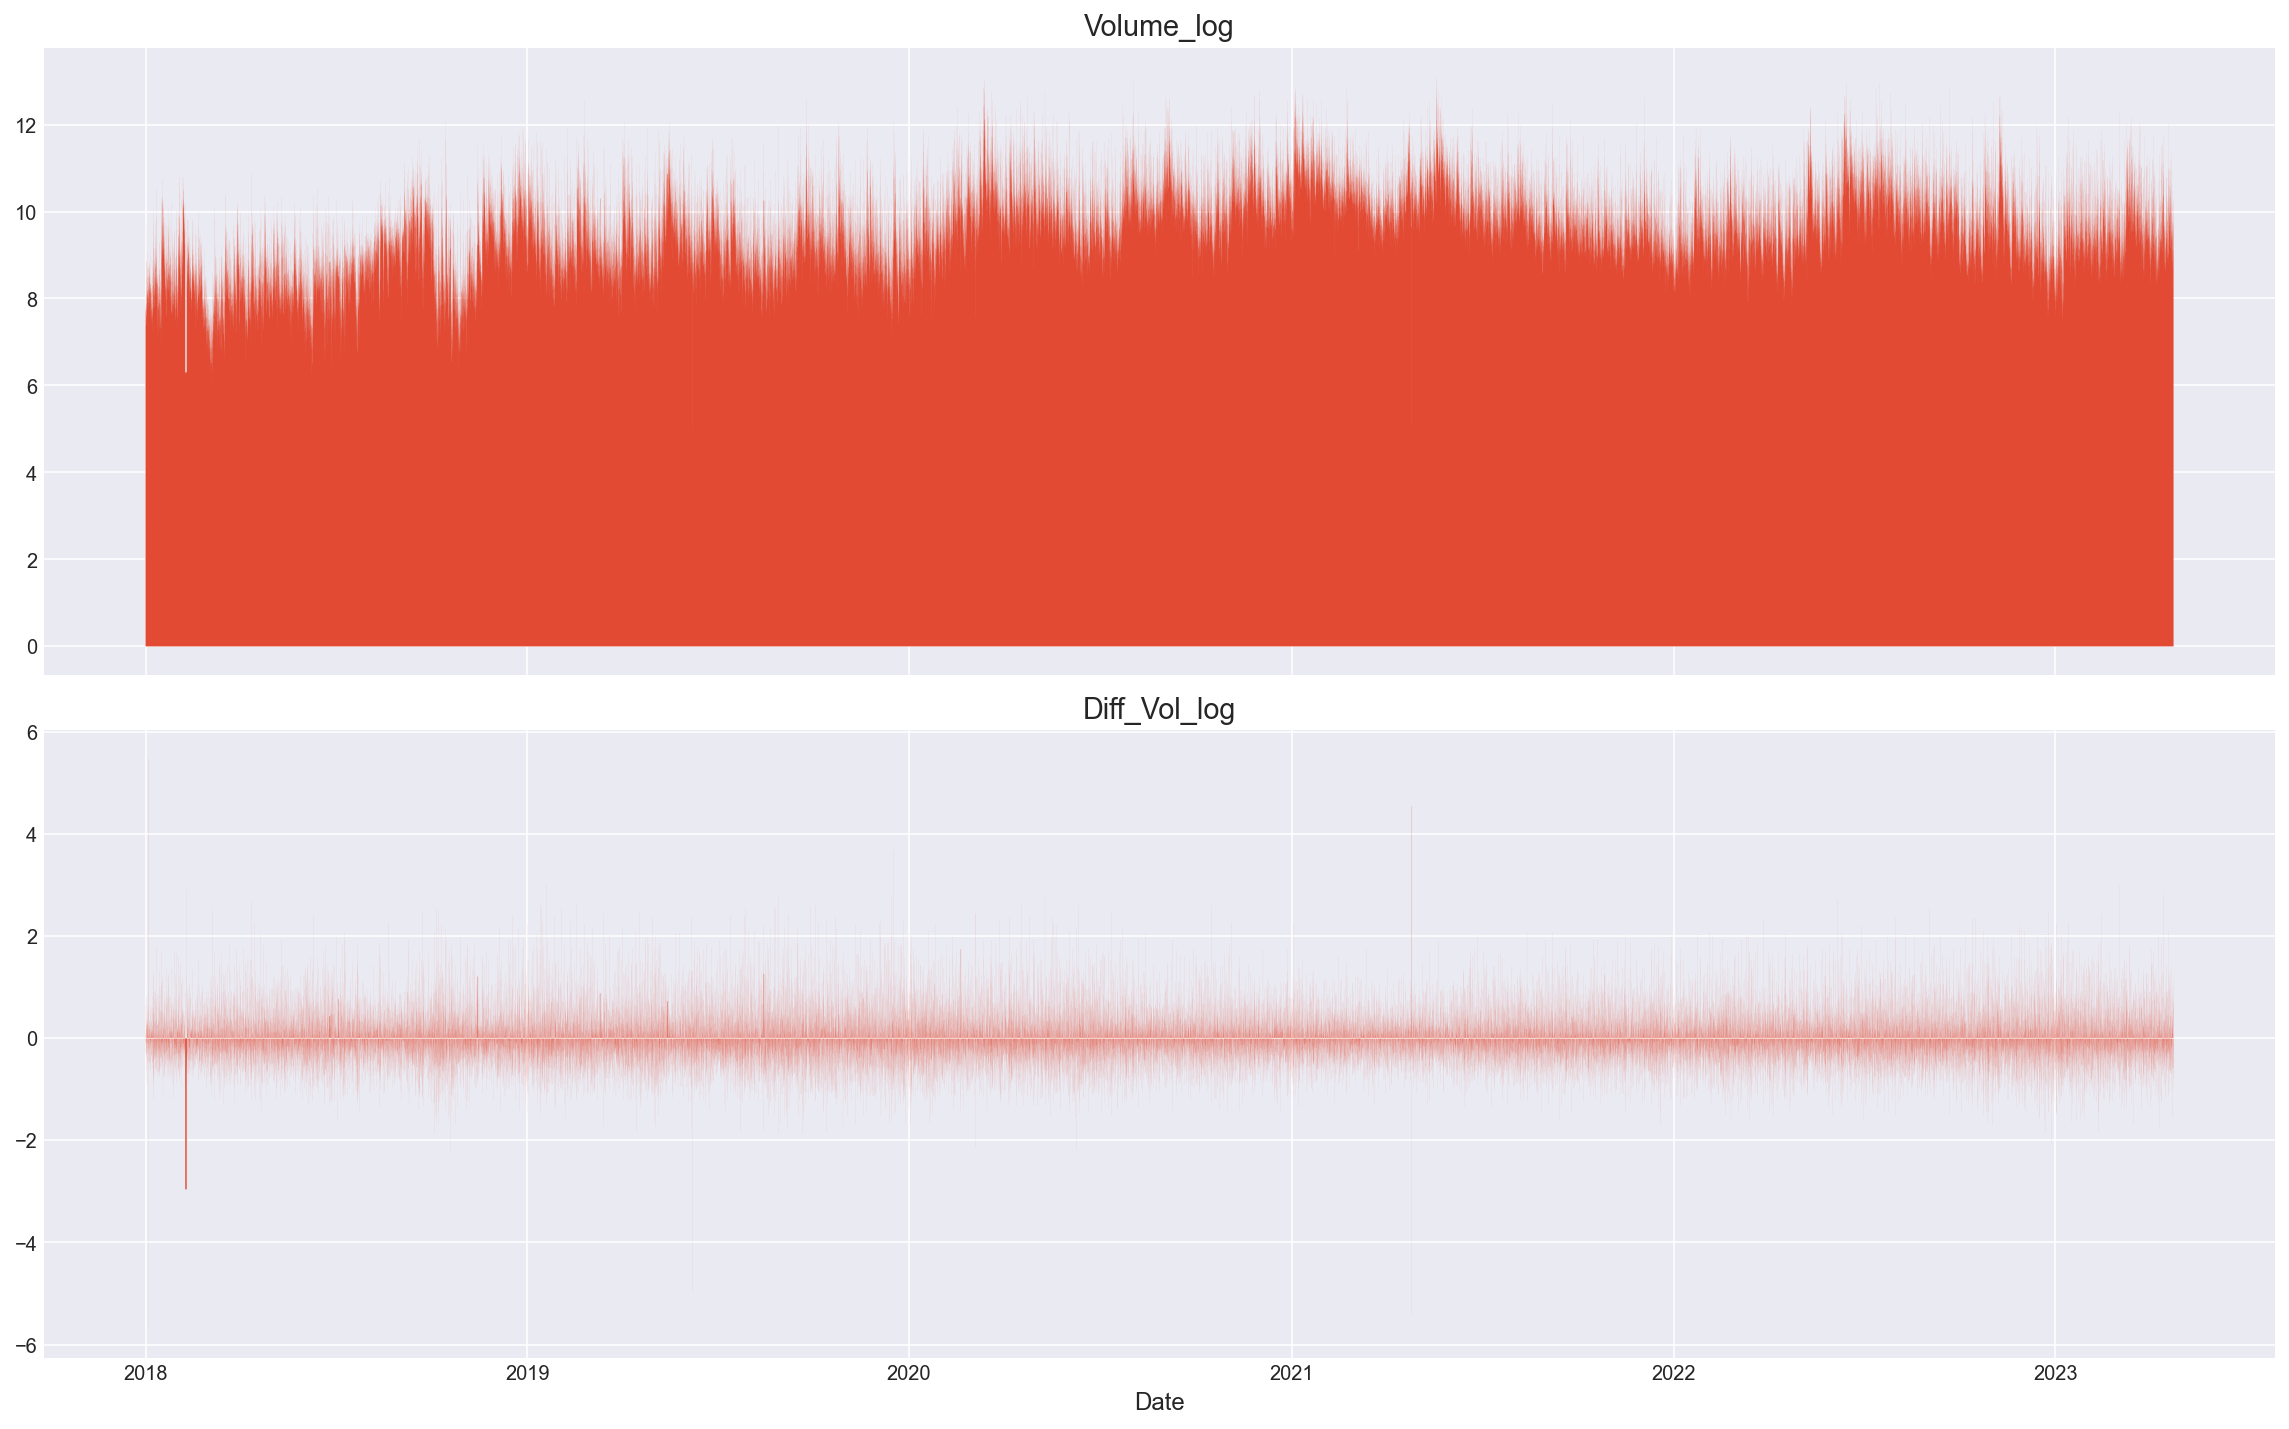

In [21]:
# If need to plot not all data
# df_to_plot = df[df.index >= '2018-01-01']
df_to_plot = df

# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert series to numpy
ind = df_to_plot.index.to_numpy()
_0 = df_to_plot['Volume_log'].to_numpy()
_1 = df_to_plot['Diff_Vol_log'].to_numpy()

ax[0].fill_between(ind, _0, step='pre')
ax[0].set_title('Volume_log')

ax[1].fill_between(ind, _1, step='pre')
ax[1].set_title('Diff_Vol_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [22]:
def add_datetime_features(df, as_category=True):
    """Функция для генерации признаков даты/времени из индекса датафрейма

    Args:
        df (_type_): исходный датафрейм
        as_category (bool, optional): Кодидровать ли созданные признаки. Defaults to True.

    Returns:
        _type_: возвращает новый датафрейм
    """
    
    new_df = df.copy()
    
    date_time = new_df.index
    new_df['M'] = date_time.month # Month
    new_df['W'] = date_time.isocalendar().week # Week from year begin
    new_df['MD'] = date_time.day # Day of Month
    new_df['WD'] = date_time.weekday # Day of Week
    new_df['H'] = date_time.hour # Hour
    
    if as_category:
        new_df['M'] = new_df['M'].astype('category')
        new_df['W'] = new_df['W'].astype('category')
        new_df['MD'] = new_df['MD'].astype('category')
        new_df['WD'] = new_df['WD'].astype('category')
        new_df['H'] = new_df['H'].astype('category')
        
    return new_df

In [23]:
df = add_datetime_features(df, as_category=True)

# Create Target Category Feature 
Создаю целевой признак

Это фактически очередные гиперпараметры.

Я могу задавать уровень риска в лог величинах - risk_level

и коэффициент доходность/риск в виде множителя - risk_factor

Т.е. текущий случай это:
* risk_level = 0.0025
* risk_factor = 4

In [ ]:
from itertools import product

In [39]:
risk_level_list = np.arange(0.001, 0.01005, 0.0005)
profit_factor_list = np.arange(1, 5.25, 0.25)
TARGET = 'Long'

zero_mo_list = []
precision_score_list = []
scores_difference_list = []

array([0.001 , 0.0015, 0.002 , 0.0025, 0.003 , 0.0035, 0.004 , 0.0045,
       0.005 , 0.0055, 0.006 , 0.0065, 0.007 , 0.0075, 0.008 , 0.0085,
       0.009 , 0.0095, 0.01  ])

In [47]:
for risk_level, profit_factor in product(risk_level_list, profit_factor_list):
    profit_level = risk_level * profit_factor
    
    zero_mo = hd.profit_margin_for_zero_mo(risk_level, profit_factor)
    zero_mo_list.append(zero_mo)
    
    df[TARGET] = np.where((df['High_Shad_log'] >= profit_level) & (df['Low_Shad_log'] <= risk_level), 1, 0)
    
    df_new = df[['Log_Return', 'High_Shad_log', 'Low_Shad_log', 'Log_Range', 'Body_share', TARGET]].copy()

    df_time = df[['H', 'WD', TARGET]].copy()
    ohe = OneHotEncoder(cols=['H', 'WD'])
    df_time = ohe.fit_transform(df_time)
    
    T = 24 # len of sequence. Num of time steps to look at to make prediction on next step
    # Create X, y
    X, y, N, D = hd.create_X_y_from_timeseries(df_new, TARGET, T)
    # Преобразование временных признаков, где не нужна последовательность, а всего лишь значение на последнем баре
    X_t, y_t, _, _ = hd.create_X_y_from_timeseries(df_time, TARGET, 1)
    # Выправляю длину, объединяю признаки
    X_t = X_t[-N:,]
    X = np.concatenate((X, X_t), axis=1)
    # Split Data
    # Разбиение с стратифиацией
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=0.2)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lr = LogisticRegression(class_weight='balanced')
    lr.fit(X_train, y_train)

    # y_train_pred = lr.predict(X_train)
    y_test_pred = lr.predict(X_test)
    precision_test = precision_score(y_test, y_test_pred)
    
    precision_score_list.append(precision_test)
    scores_difference_list.append(precision_test - zero_mo) # нужно полодительное значение